In [41]:
import netCDF4
import numpy as np
import datetime
import sys
import matplotlib.pyplot as plt
import roppy # https://github.com/bjornaa/roppy
import matplotlib
import re
from io import StringIO  # Import StringIO from the standard library
import gsw
import pandas as pd


In [42]:
def roms_latlon2xy(f,lat,lon,roundvals=True):
    a = abs( f.variables['lat_rho'][:]-lat ) + abs( f.variables['lon_rho'][:]-lon )
    y_coord, x_coord = np.unravel_index(a.argmin(), a.shape)
    if roundvals:
        x_coord = int(np.round(x_coord))
        y_coord = int(np.round(y_coord))
    return x_coord, y_coord

def BFS(start_i, start_j, arr, crit=1):
    """
    Code from josteinb@met.no

    desc:
        Breadth first search function to find index of nearest
        point with crit value (default crit=1 for finding ROMS
        wet-point in mask)
    args:
        - start_i: Start index of i
        - start_j: Start index of j
        - arr: grid with data
        - crit: value to search for (deafult unmasked point)
    return:
        - index of point
    """
    dirs    = [(1,0), (-1,0), (0,1),(0,-1)]
    visited = set()
    q       = [(start_i, start_j)]    # init queue to start pos
    count   = 0
    arrays  = list()  # for storing frames if plotting
    # while something in queue
    while q:
        current = q.pop(0)      # pop the first in waiting queue
        # if we have visited this before
        if current in visited:
            continue
        visited.add(current)    # Add to set of visited
        # If not in border list
        # Test if this is land, if true go to next in queue, else return idx
        if arr[current[0], current[1]] == crit:
            return current[0], current[1]
        count += 1      #updates the count
        # Loop over neighbours and add to queue
        for di, dj in dirs:
            new_i = current[0]+di
            new_j = current[1]+dj
            q.append((new_i, new_j))

def get_z(grd):
    import roppy
    h      = grd.variables['h']
    C      = grd.variables['Cs_r'][:]
    Cw     = grd.variables['Cs_w'][:]
    Hc     = grd.variables['hc'].getValue()
    vtrans = grd.variables['Vtransform'].getValue()
    z_rho  = roppy.sdepth(h, Hc, C, Vtransform=vtrans)
    z_w    = roppy.sdepth(h, Hc, Cw, Vtransform=vtrans)
    return z_rho, z_w

In [43]:
date = "20230928"  # date is needed for correct file name
filename = f"https://thredds.met.no/thredds/dodsC/fjordos/operational_archive/complete_archive/ocean_his.nc_{date}00"

nc       = netCDF4.Dataset(filename)
# for var_name, var in nc.variables.items():
#     print(f"Variable Name: {var_name}")
#     print(f"Dimensions: {var.dimensions}")
#     print(f"Shape: {var.shape}")
#     print(f"Data Type: {var.dtype}")
#     print(f"Attributes: {var.__dict__}")  # Print variable attributes
#     print("-" * 30)
lat      = [59.88]#, 59.88, 59.86, 59.86] 
lon      = [10.65]#, 10.65, 10.70, 10.70]
name     = ['Nesoddetangen_example']#,'Nesoddetangen_example','Nesoddetangen_example','Nesoddetangen_example']
times    = [datetime.datetime(2023,9,28,7)]#,
            # datetime.datetime(2023,9,28,13),
            # datetime.datetime(2023,9,28,8),
            # datetime.datetime(2023,9,28,12)]  # Format year, month, day, hour. Date needs to be the same as  "date" above.
loc      = ["A"]#, "A", "C", "C"]

In [44]:
# Check all arrays length:
if not (len(lat) == len(lon) == len(name) == len(times)):   
    print('Error in array lengths')
    raise()

In [45]:
# Read vertical layers depth:
z_rho, z_w = get_z(nc)

# Plotting handheld, ship and model profiles all in one figure

In [46]:


plt.style.use("ggplot")
# matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({
    'font.size': 18,          # Adjust the font size as needed
    'font.family': 'serif'   # Choose the font family (e.g., 'serif', 'sans-serif', 'monospace')
})

def plot_combined(handeld_file_path, ship_file_path, station_name, lat, lon, time):
    date = "20230928"  # date is needed for correct file name
    filename = f"https://thredds.met.no/thredds/dodsC/fjordos/operational_archive/complete_archive/ocean_his.nc_{date}00"

    nc       = netCDF4.Dataset(filename)
    # for var_name, var in nc.variables.items():
    #     print(f"Variable Name: {var_name}")
    #     print(f"Dimensions: {var.dimensions}")
    #     print(f"Shape: {var.shape}")
    #     print(f"Data Type: {var.dtype}")
    #     print(f"Attributes: {var.__dict__}")  # Print variable attributes
    #     print("-" * 30)
    lat      = [lat]#, 59.88, 59.86, 59.86] 
    lon      = [lon]#, 10.65, 10.70, 10.70]
    name     = ['Nesoddetangen_example']#,'Nesoddetangen_example','Nesoddetangen_example','Nesoddetangen_example']
    times    = [datetime.datetime(2023,9,28,time)]#,
                # datetime.datetime(2023,9,28,13),
                # datetime.datetime(2023,9,28,8),
                # datetime.datetime(2023,9,28,12)]  # Format year, month, day, hour. Date needs to be the same as  "date" above.
    loc      = ["A"]#, "A", "C", "C"]
    ########################  HANDHELD  ############################
    column_names = ["Pressure", "Depth","Temperature" ,"Conductivity" ,"Specific conductance" ,"Salinity" ,"Sound velocity" ,"Density"]
    # meatadata
    df_info = pd.read_csv(handeld_file_path, header=None, nrows=28)
    # lat, lon = float(df_info.iloc[9,1]), float(df_info.iloc[10,1])
    start_time, duration = df_info.iloc[2,1], df_info.iloc[21,1] #UTC, seconds

    # hydrographic data
    df = pd.read_csv(handeld_file_path, names = column_names, skiprows=29)
    P = df["Pressure"]
    T = df["Temperature"]
    S = df["Salinity"]
    depth = df["Depth"]
    rho = df["Density"]

    a=.8
    fig, axes = plt.subplots(1, 3, figsize=(10*a, 7*a), sharey=True)
    
    font_s = 16

    axes[0].tick_params(axis='both', labelsize=font_s-1)
    axes[1].tick_params(axis='both', labelsize=font_s-1)
    axes[2].tick_params(axis='both', labelsize=font_s-1)


    # Plot Density vs. Depth
    axes[0].plot(rho-1000, depth, color="blue", label="Handheld", zorder=3)
    axes[0].set_xlabel('Density $[kg/m^3]$', fontsize=font_s)
    # axes[0].set_ylabel('Depth')
    axes[0].invert_yaxis()

    # Plot Temperature vs. Depth
    axes[1].plot(T, depth, color="red", label="Handheld", zorder=3)
    axes[1].set_xlabel('Temperature [$C^{\\circ}$]', fontsize=font_s)
    axes[1].invert_yaxis()

    # Plot Salinity vs. Depth
    axes[2].plot(S, depth, color="green", label="Handheld", zorder=3)
    axes[2].set_xlabel('Salinity $[PSU]$', fontsize=font_s)
    axes[2].invert_yaxis()

    # Add a main title
    # plt.suptitle(f"Handheld CTD, {station_name}\n Lat: {lat:.2f}, Lon: {lon:.2f}, Time(UTC): {start_time}")#, Duration: {duration}")

    # Adjust spacing between subplots
    # plt.tight_layout()

    # Share y-axis labels and set a common y-axis label for the row of subplots
    axes[0].set_ylabel('Depth [m]', fontsize=font_s)
    axes[0].set_ylim(52, 0) 
    ########################  SHIP  ############################

    # Initialize variables to store metadata and data
    metadata = {}
    data_lines = []
    system_upload_time = None  # Initialize the system upload time variable

    # Read the file and extract metadata and data
    with open(ship_file_path, 'r') as file:
        in_metadata = True
        for line in file:
            if in_metadata:
                # Parse metadata using regular expressions
                match = re.match(r'# name (\d+) = (\S+): (.+)', line)
                if match:
                    index, name_, description = match.groups()
                    metadata[int(index)] = (name_, description)
                elif line.startswith('* System UTC'):
                    # Extract the System UpLoad Time
                    system_upload_time = line.split('=')[-1].strip()
            else:
                data_lines.append(line)
            if line.strip() == "*END*":
                in_metadata = False

    # Create a pandas DataFrame from the data lines with space as the delimiter
    # Use the extracted names as column names
    column_names = [metadata[i][0] for i in range(len(metadata))]
    df = pd.read_csv(StringIO('\n'.join(data_lines)), delim_whitespace=True, names=column_names)


    depth = df["depSM"]
    S = df["sal00"]
    P = df["prDM"]
    T = df["t090C"]
    rho = df["sigma-t00"]

    # a=.8
    # fig, axes = plt.subplots(1, 3, figsize=(10*a, 7*a), sharey=True)

    # font_s = 16

    axes[0].tick_params(axis='both', labelsize=font_s-1)
    axes[1].tick_params(axis='both', labelsize=font_s-1)
    axes[2].tick_params(axis='both', labelsize=font_s-1)

    # Plot Density vs. Depth
    axes[0].plot(rho, depth, color = "cornflowerblue", label="Ship", lw=3)
    axes[0].set_xlabel('Density $[kg/m^3]$', fontsize=font_s)
    # axes[0].set_ylabel('Depth')
    axes[0].invert_yaxis()

    # Plot Temperature vs. Depth
    axes[1].plot(T, depth, color="lightcoral", label="Ship", lw=3)
    axes[1].set_xlabel('Temperature [$C^{\\circ}$]', fontsize=font_s)
    axes[1].invert_yaxis()

    # Plot Salinity vs. Depth
    axes[2].plot(S, depth, color="limegreen", label="Ship", lw=3)
    axes[2].set_xlabel('Salinity $[PSU]$', fontsize=font_s)
    axes[2].invert_yaxis()

    # Add a main title
    # plt.suptitle(f"Ship CTD, {measurment_name}\nTime(UTC): {system_upload_time}")

    # Adjust spacing between subplots
    plt.tight_layout()

    # Share y-axis labels and set a common y-axis label for the row of subplots
    axes[0].set_ylabel('Depth $[m]$', fontsize = font_s)

    ##############
    # Show the plots
    # plt.savefig(f"figures/ship_ctd/ship_ctd_{measurment_name.replace(',', '').replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    # plt.show()

    ####################### MODEL #####################
    # Loop over all stations:
    print(lat)
    for i in range(len(name)):
        x, y = roms_latlon2xy(nc, lat[i], lon[i]) # find x and y indexes
        t    = np.where(netCDF4.num2date(nc.variables['ocean_time'][:], nc.variables['ocean_time'].units) == times[i])[0][0] # find time index
        mask = nc.variables['mask_rho'][:]
        if mask[y,x] == 0:
            print('Position is on land, will find nearest wet gridpoint')
            y, x = BFS(y,x,mask)
        salt = nc.variables['salt'][t,:,y,x]
        temp = nc.variables['temp'][t,:,y,x]


        # get density using gsw 
        rho = gsw.rho(salt, temp, 0)


        matplotlib.rcParams.update({
        'font.size': 18,          # Adjust the font size as needed
        'font.family': 'serif'   # Choose the font family (e.g., 'serif', 'sans-serif', 'monospace')
        })
        plt.style.use("ggplot")

        
        # # Create a figure with three subplots in one row, sharing the same y-axis
        # a=.8
        # fig, axes = plt.subplots(1, 3, figsize=(10*a, 7*a), sharey=True)

        # font_s = 16

        axes[0].tick_params(axis='both', labelsize=font_s-1)
        axes[1].tick_params(axis='both', labelsize=font_s-1)
        # axes[2].tick_params(axis='both', labelsize=font_s-1)

        # Plot Density vs. Depth
        axes[0].plot(rho-1000, -z_rho[:,y,x], "--", color = "tab:blue", label="ROMS")
        axes[0].set_xlabel('$\\sigma_t$ $[kg/m^3]$', fontsize=font_s)
        # axes[0].set_ylabel('Depth')
        axes[0].invert_yaxis()

        # Plot Temperature vs. Depth
        axes[1].plot(temp, -z_rho[:,y,x], "--", color="tab:red", label="ROMS")
        axes[1].set_xlabel('$\\theta$ [$C^{\\circ}$]', fontsize=font_s)
        # axes[1].invert_yaxis()

        # Plot Salinity vs. Depth
        axes[2].plot(salt, -z_rho[:,y,x], "--",color="tab:green", label="ROMS")
        axes[2].set_xlabel('Salinity $[PSU]$', fontsize=font_s)
        # axes[2].invert_yaxis()

        # Add a main title
        # plt.suptitle(f"ROMS Model, Location {loc[i]}\nLat: {lat[i]} Lon: {lon[i]} Time(UTC): {times[i]}", fontsize=22)
        plt.suptitle(f"{station_name}", fontsize=22)


        # Adjust spacing between subplots
        plt.tight_layout()

        # Share y-axis labels and set a common y-axis label for the row of subplots
        axes[0].set_ylabel('Depth $[m]$', fontsize = font_s)
        axes[0].set_ylim(52, 0)
        axes[0].set_xlim(10, 30)
        axes[1].set_xlim(6, 18)
        axes[2].set_xlim(10, 35)




        ##############
        # Show the plots
    #########################
        axes[0].legend(fontsize=13, loc='lower left').get_frame().set_alpha(0.5) 
        axes[1].legend(fontsize=13, loc='lower right').get_frame().set_alpha(0.5) 
        axes[2].legend(fontsize=13, loc='lower left').get_frame().set_alpha(0.5) 
        plt.savefig(f"figures/combined_profiles/{station_name.replace(' ', '_').replace(',', '')}.png", dpi=300, bbox_inches='tight')


        plt.show()



  

In [47]:
# plot_ship_ctd("data/ship_ctd/BN1_LYSF_280923_tokt2.cnv", "Measurement 3, Location A")
# plot_ship_ctd("data/ship_ctd/BN1_LYSF_280923.cnv", "Measurement 1, Location A")
# plot_ship_ctd("data/ship_ctd/BN1-Lysakerfjorden_280923_tokt2.cnv", "Measurement 6, Location A")
# plot_ship_ctd("data/ship_ctd/CP1_Oksvallflua_280923_2.cnv", "Measurement 2, Location C")
# plot_ship_ctd("data/ship_ctd/Driftboyeposisjon_280923_tokt2.cnv", "Measurement 4, Location C")
# plot_ship_ctd("data/ship_ctd/R2_280923_tokt2.cnv", "Measurement 5, Location B")

# station1 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_071740.csv", "Measurement 1, Location A")
# station2 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_081103.csv", "Measurement 2, Location C")
# station3 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_111127.csv", "Measurement 3, Location A")
# station4 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_120545.csv", "Measurement 4, Location C")
# station5 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_124649.csv", "Measurement 5, Location B")
# station6 = plot_handheld_ctd("data/handheld_ctd/CC2240001_20230928_130109.csv", "Measurement 6, Location A")

[59.88]


/var/folders/2v/2w0m8sk55n3cwrk5n76h1bw80000gn/T/ipykernel_37008/899073309.py:211: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


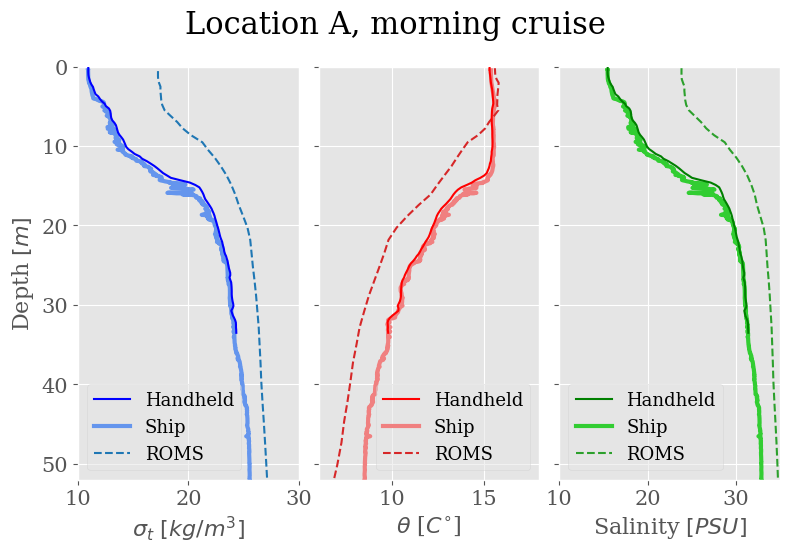

[59.88]


/var/folders/2v/2w0m8sk55n3cwrk5n76h1bw80000gn/T/ipykernel_37008/899073309.py:211: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


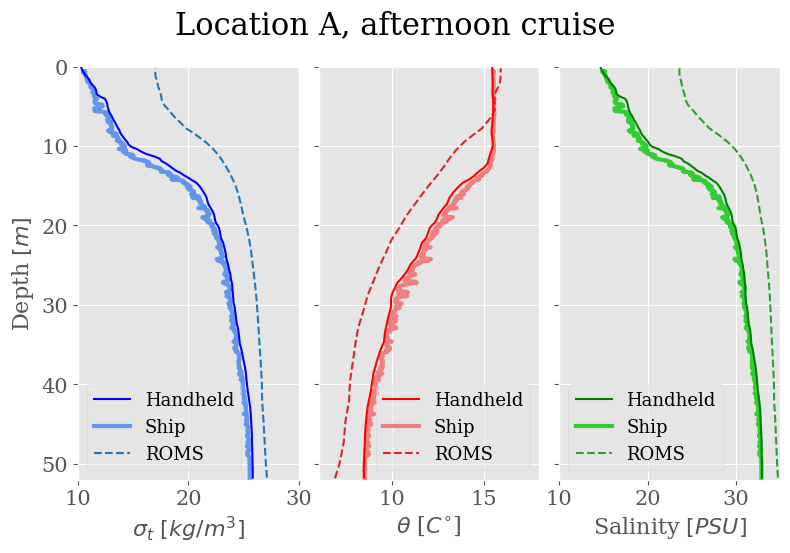

[59.86]


/var/folders/2v/2w0m8sk55n3cwrk5n76h1bw80000gn/T/ipykernel_37008/899073309.py:211: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


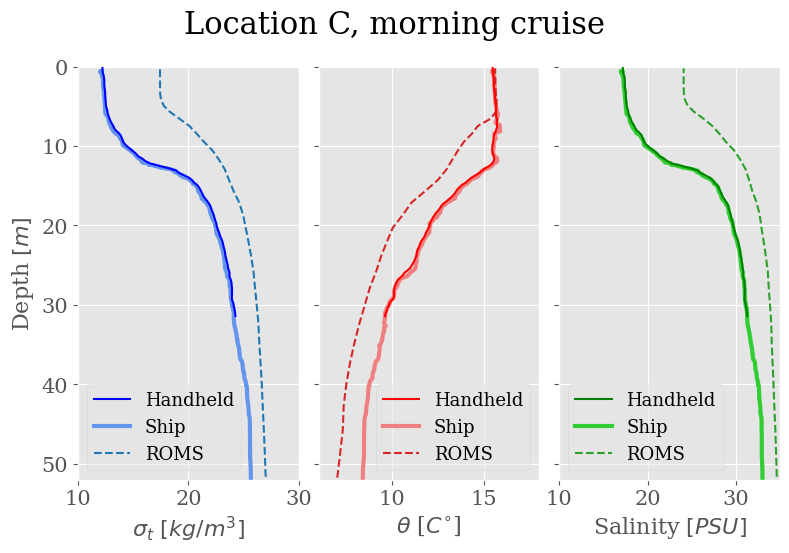

[59.86]


/var/folders/2v/2w0m8sk55n3cwrk5n76h1bw80000gn/T/ipykernel_37008/899073309.py:211: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


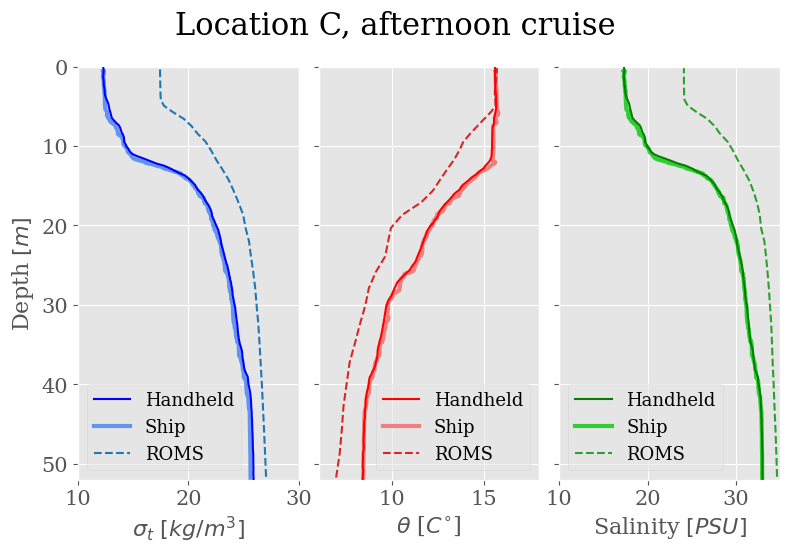

[59.89]


/var/folders/2v/2w0m8sk55n3cwrk5n76h1bw80000gn/T/ipykernel_37008/899073309.py:211: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


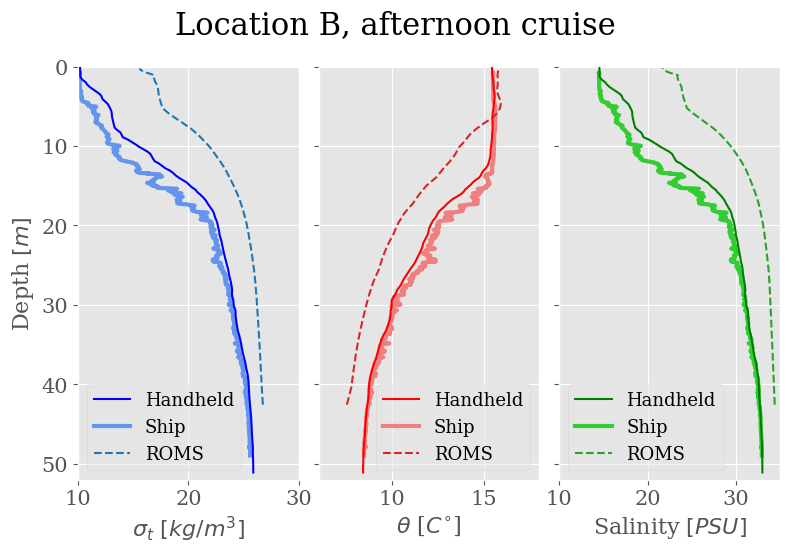

In [48]:
plot_combined("data/handheld_ctd/CC2240001_20230928_071740.csv", "data/ship_ctd/BN1_LYSF_280923.cnv", "Location A, morning cruise", 59.88, 10.65, 7)
plot_combined("data/handheld_ctd/CC2240001_20230928_130109.csv", "data/ship_ctd/BN1-Lysakerfjorden_280923_tokt2.cnv", "Location A, afternoon cruise", 59.88, 10.65, 13)

plot_combined("data/handheld_ctd/CC2240001_20230928_081103.csv", "data/ship_ctd/CP1_Oksvallflua_280923_2.cnv", "Location C, morning cruise", 59.86, 10.70, 8)
plot_combined("data/handheld_ctd/CC2240001_20230928_120545.csv", "data/ship_ctd/Driftboyeposisjon_280923_tokt2.cnv", "Location C, afternoon cruise", 59.86, 10.70, 12)

plot_combined("data/handheld_ctd/CC2240001_20230928_124649.csv", "data/ship_ctd/R2_280923_tokt2.cnv", "Location B, afternoon cruise", 59.89, 10.67, 13)



